In [47]:
import numpy as np
import matplotlib.pyplot as plt

from ase.io import read

import abtem

import os
os.environ["MKL_NUM_THREADS"] = "1"

# STEM simulations with PRISM

Multslice simulations from STEM images can be very slow because the scattering of the electron probe is calculated from scratch at each pixel of the image. An alternative is to use the [PRISM algorithm](https://prism-em.com) developed by Colin Ophus. PRISM almost always provides a decent speed-up for images with many probe positions, and allows for huge speedups, at a modest cost to accuracy, by using Fourier interpolation.

## Basic simulations

In abTEM, you simulate STEM images using a `SMatrix` object. This requires two parameters that are quite different than in STEM with the normal multislice method. 

The `planewave_cutoff` corresponds to the maximum scattering angle computed for the S-Matrix, and its value should be set slightly larger than the probe semiangle cutoff, which we will set later. Increasing this value, also increases the number of plane wave in the probe expansion, and hence the cost and memory of the simulation.

By setting the interpolation factor to one, the PRISM algorithm converges to the normal multislice method. Increasing this factor decreases the accuracy of PRISM, but the tradeoff can be very favorable. More on how to choose this later.

[########################################] | 100% Completed |  0.1s


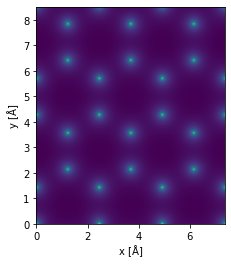

In [44]:
atoms = read('data/orthogonal_graphene.cif') 

potential = abtem.Potential(atoms, projection='infinite', sampling=.025)

potential.show()

In [59]:
s_matrix = abtem.SMatrix(
    potential=potential,
    energy=100e3,
    planewave_cutoff=30,
    interpolation=1)

detector = abtem.AnnularDetector(inner=60, outer=150)

Here we simulate the same graphene image earlier in our walkthrough, but now using PRISM.

In [80]:
%%time
image_prism = s_matrix.scan(detectors=detector)

image_prism.compute()

[########################################] | 100% Completed |  3.3s
Wall time: 3.35 s


As a comparison, we do the same calculation using the standard multislice algorithm with a `Probe`.

In [81]:
%%time
image_multislice = abtem.Probe(energy=100e3, semiangle_cutoff=30).scan(potential=potential, detectors=detector)
image_multislice.compute()

[########################################] | 100% Completed |  7.9s
Wall time: 7.94 s


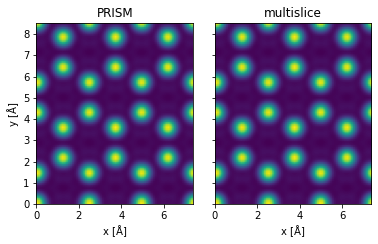

In [82]:
abtem.stack([image_prism, image_multislice], axis_metadata=('PRISM', 'multislice')).interpolate(.1).show(explode=True)

The results are identical to within the 32 bit floating point acurracy. However, the PRISM simulation ran about 3 times faster in this particular case.

In [66]:
image_prism == image_multislice

True

The standard multislice algorithm requires rerunning it from scratch for each probe position. The present simulation requires 837 probe positions to cover the potential at Nyquist sampling, whereas the PRISM scattering matrix required 123 plane waves to describe the probe. 

PRISM will provide a larger speedup 

In [75]:
np.prod(image_multislice.shape), len(s_matrix)

(837, 123)

The stack of plane waves 

In [130]:
s_matrix_array = s_matrix.build().compute()

[########################################] | 100% Completed |  2.2s


In [133]:
#s_matrix_array.waves.axes_metadata

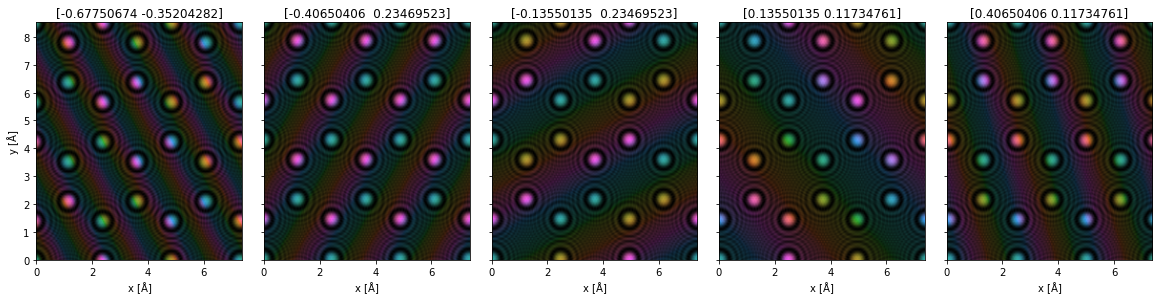

In [134]:
s_matrix_array.waves.complex_images()[::25].show(explode=True, figsize=(20,20))

In [102]:
len(s_matrix_array.waves) // 10

12

## The scattering matrix array

The `SMatrix` object handles the PRISM algorithm behind the scenes. For more control you can build the scattering matrix to obtain a `SMatrixArray`. This is equivalent to the `SMatrix`, however it is now represented as an array.

In [68]:
s_matrix_array = s_matrix.build()
s_matrix_array.compute()

[########################################] | 100% Completed |  2.4s


In [74]:
s_matrix_array.waves[np.array([0,10,20],dtype=int)]

NotImplementedError: indices must be integers or slices, or a tuple of integers or slices

The plane wave expansion as a numpy array can be obtained as `S_array.array`. Its first dimension indexes the plane waves by their 2D wave vector, given in the array `S_array.k`. In this case the expansion consists of 119 plane waves.

In [7]:
S_array.array.shape, S_array.k.shape

((119, 246, 285), (119, 2))

To obtain a probe wave function, we have to sum up the expansion, given a particular set of positions. This can be done with the `.collapse` method.

(<AxesSubplot:xlabel='x [Å]', ylabel='y [Å]'>,
 <matplotlib.image.AxesImage at 0x24591d98e20>)

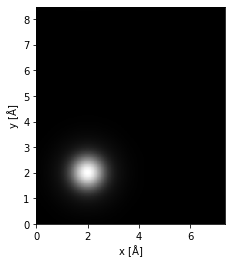

In [8]:
probes = S_array.collapse(positions=[(2,2),(5,5)])

probes[0].show()

We can propagate the scattering matrix through the potential.

In [9]:
exit_S_array = S_array.multislice(potential)

The imaging parameters of the represented probes can be modified after performing the multislice simulation using the builtin contrast transfer function.

In [10]:
exit_S_array.ctf.semiangle_cutoff = 20
exit_S_array.ctf.defocus = -50

We can finally perform the STEM simulation.

In [11]:
exit_S_array.scan(gridscan, [detector]);

## Interpolation factor

To increase speed, we can use interpolation. The highest spatial frequency included in the plane wave expansion will be reduced by the interpolation factor. This can more intuitively be thought of as restricting the extent of the probe window. We copy the scattering matrix above and set its interpolation factor to 2.

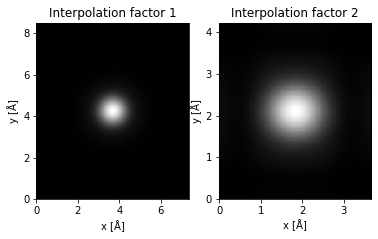

In [12]:
S2 = S.copy()
S2.interpolation = 2

fig, (ax1, ax2) = plt.subplots(1, 2)
S.show(ax=ax1)
ax1.set_title('Interpolation factor 1')

S2.show(ax=ax2)
ax2.set_title('Interpolation factor 2');

The simulation was faster, however, we see huge errors in the resulting image.

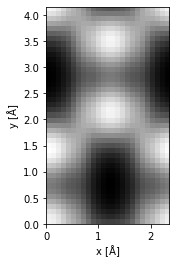

In [13]:
measurements2 = S2.scan(gridscan, detector, potential, pbar=False)
measurements2.show();

The error arises because the probe is too large to fit in the probe window. Our unit cell is so small that it is here possible to use interpolation (for this probe size). This would of course be different for larger cells with thousands of atoms.

We emulate that situation by just repeating the unit cell by a factor of 2.

In [14]:
potential2 = Potential(atoms * (2, 2, 1), sampling=.03)

The multislice part of the simulation will be more expensive, however, due to the interpolation, the scanning part costs virtually the same.

In [15]:
measurement3 = S2.scan(gridscan, detector, potential2, pbar=True)

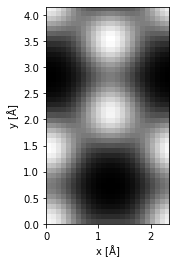

In [16]:
measurement3.show();